## Name: HABIMANA Martin
### Assignment 2 of introduction to neural network
#### On 9/ March/ 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

In [2]:
IMG_LEN = 28
IMG_SIZE = IMG_LEN**2

In [3]:
class QuadraticLoss(object):
    @staticmethod
    def loss(a, y):
        return 0.5*np.dot(a-y, a-y)
    @staticmethod
    def loss_derivative(a, y):
        return a-y

In [4]:
class CrossEntropyLoss(object):
    @staticmethod
    def loss(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def loss_derivative(a, y):
        return (a-y)/(a*(1.0-a))

In [5]:
class Network(object):
    def __init__(self, n, *, loss=QuadraticLoss, init='standard'):
        # Initialize the weights randomly
        if init == 'standard':
            self.W = np.random.randn(n, IMG_SIZE)
            self.V = np.random.randn(10, n)
        elif init == 'normalized':
            self.W = np.random.randn(n, IMG_SIZE) / np.sqrt(IMG_SIZE)
            self.V = np.random.randn(10, n) / np.sqrt(n)
        
        self.b = np.random.randn(n)
        self.bprime = np.random.randn(10)
        self.loss = loss
        
    def feedforward(self, x):
        # Return the output of a feedforward pass
        a = sigmoid(np.dot(self.W, x)+self.b)
        return sigmoid(np.dot(self.V, a)+self.bprime)
    
    def evaluate(self, data, *, lmbda=0):
        """ Return (cost, accuracy) on the data"""
        correct_samples = 0
        total_cost = 0
        n_samples = len(data)
        
        for x, ylabel in data:
            y = self.feedforward(x)
            prediction = np.argmax(y)
            if prediction == ylabel:
                correct_samples += 1
            
            total_cost += self.loss.loss(y, Network.vec_output[ylabel])
        
        average_cost = total_cost / n_samples
        average_cost += 0.5*lmbda*(
            np.linalg.norm(self.W)**2 + np.linalg.norm(self.V)**2)
        
        return average_cost, correct_samples / n_samples
            
    
    def update_mini_batch(self, mini_batch, eta, lmbda):
        # Run backprop and update weights on the minibatch
        k = len(mini_batch)
        delta_W = np.zeros(self.W.shape)
        delta_b = np.zeros(self.b.shape)
        delta_V = np.zeros(self.V.shape)
        delta_bprime = np.zeros(self.bprime.shape)
        
        for x, y in mini_batch:
            nabla_W, nabla_b, nabla_V, \
                nabla_bprime = self.backprop(x, y)
            delta_W += nabla_W
            delta_b += nabla_b
            delta_V += nabla_V
            delta_bprime += nabla_bprime
        
        self.W -= eta*(lmbda*self.W + 1/k * delta_W)
        self.b -= eta/k * delta_b
        self.V -= eta*(lmbda*self.V + 1/k * delta_V)
        self.bprime -= eta/k * delta_bprime
        
    def SGD_with_early(self, training_data, *, thre, mini_batch_size, eta, lmbda=0, test_data=[]):
        result,stop,epochs = [0],list(range(10)),0
        while max(stop)-min(stop) > thre :
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta, lmbda)
                
            result.append((self.evaluate(training_data),
                       self.evaluate(test_data)))
            stop= stop[1::]
            epochs+= 1
            stop.append(result[epochs][1][1])
            
            print('Epoch '+str(epochs-1)+' finished')
        
        return result[1::]    

    def SGD(self, training_data, *, epochs, mini_batch_size, 
            eta, lmbda=0, test_data=[]):
        # Run SGD with those parameters
        # Return a list of results for every epoch
        # For each epoch, append pair (self.evaluate(training_data), 
        #        self.evaluate(test_data))
        res = []

        for i in range(epochs):
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta, lmbda)
                
            res.append((self.evaluate(training_data),
                       self.evaluate(test_data)))
            
            print('Epoch '+str(i)+' finished')
        
        return res
        
    def backprop(self, x, ylabel):
        # feedforward
        z1 = np.dot(self.W, x)+self.b
        a1 = sigmoid(z1)
        z2 = np.dot(self.V, a1)+self.bprime
        a2 = sigmoid(z2)
        
        # backward
        delta_2 = self.loss.loss_derivative(a2, Network.vec_output[ylabel]) * sigmoid_prime(z2)
        nabla_bprime = delta_2
        nabla_V = np.outer(delta_2, a1)
        
        delta_1 = np.dot(self.V.transpose(), delta_2) * sigmoid_prime(z1)
        nabla_b = delta_1
        nabla_W = np.outer(delta_1, x)
        
        return nabla_W, nabla_b, nabla_V, nabla_bprime
    
    vec_output = []
    for ylabel in range(10):
        V = np.zeros(10)
        V[ylabel] = 1
        vec_output.append(V)

In [6]:
def sigmoid(z):
    return 1 / (1.0+np.exp(-z))
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [7]:
def load_data():
    # Note you have to update the path below
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return training_data, validation_data, test_data

In [8]:
TRAIN, VALIDATION, TEST = load_data()

In [9]:
def zip_data(D):
    return list(zip(D[0], D[1]))

In [10]:
train_data = zip_data(TRAIN)
validation_data = zip_data(VALIDATION)
test_data = zip_data(TEST)

In [11]:
def plot_results(res):
    X = list(range(len(res)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    train_acc = [x[0][1] for x in res]
    test_acc = [x[1][1] for x in res]
    ax1.plot(X, train_acc, label='train')
    ax1.plot(X, test_acc, label='test')
    ax1.legend()
    
    train_cost = [x[0][0] for x in res]
    test_cost = [x[1][0] for x in res]
    ax2.plot(X, train_cost, label='train')
    ax2.plot(X, test_cost, label='test')
    ax2.legend()
    
    print(np.max([x[1][1] for x in res]))

### Original training

In [12]:
NET = Network(30,loss=CrossEntropyLoss)
results = NET.SGD(train_data,
                  epochs=30,
                  mini_batch_size=10,
                  eta=3.0,
                  test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9501


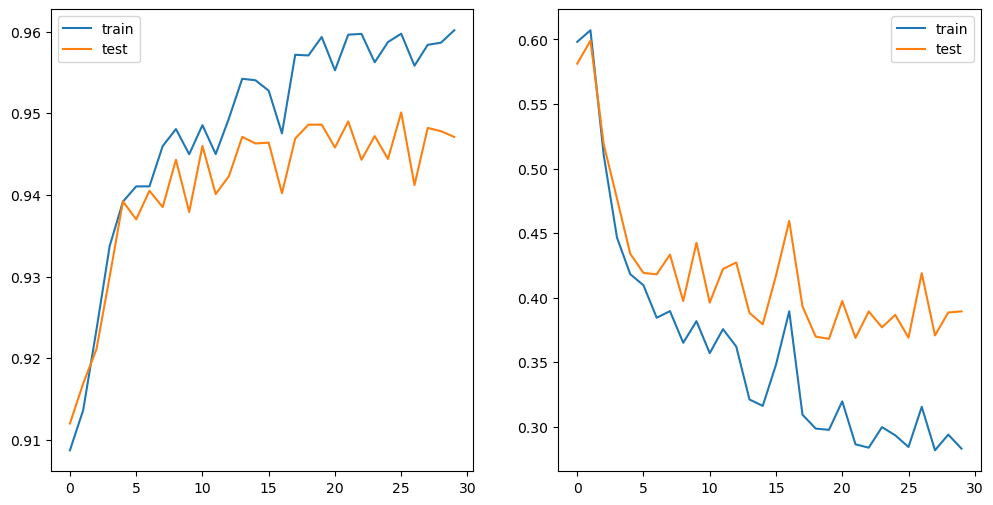

In [13]:
plot_results(results)

### Cross-entropy loss, $\eta=3.0$

In [14]:
NET = Network(30, loss=CrossEntropyLoss)

In [15]:
results = NET.SGD(train_data, 
                  epochs=30, 
                  mini_batch_size=10, 
                  eta=3.0, 
                  test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9493


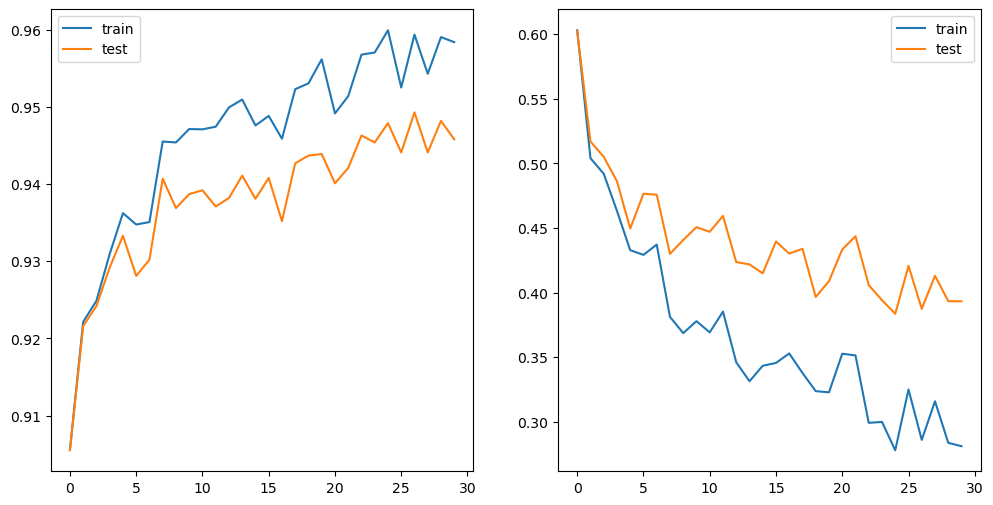

In [16]:
plot_results(results)

### Cross-entropy loss, $\eta=0.5$

In [17]:
NET2 = Network(30, loss=CrossEntropyLoss)
results2 = NET2.SGD(train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9529


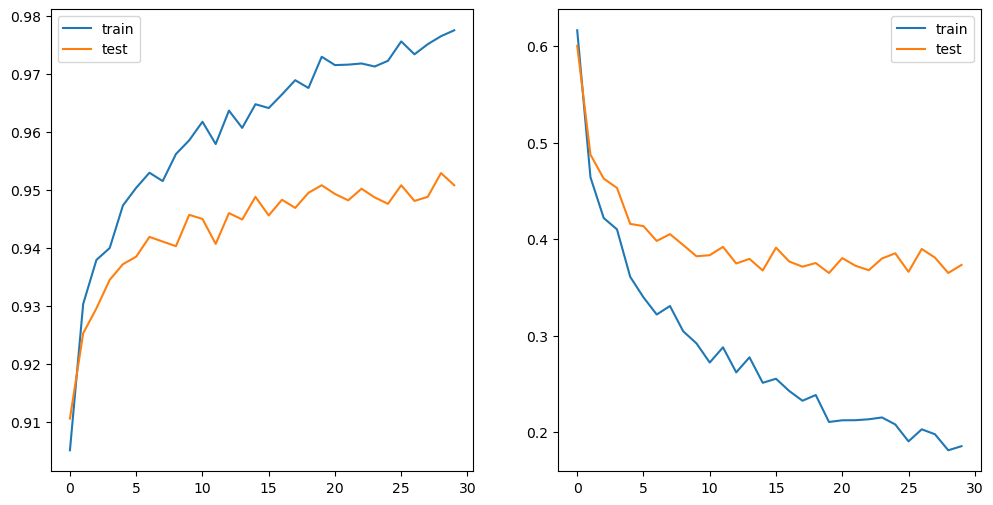

In [18]:
plot_results(results2)

### Added L2 regularization, $\lambda=10^{-4}$

In [19]:
NET3 = Network(30, loss=CrossEntropyLoss)
results3 = NET3.SGD(train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9621


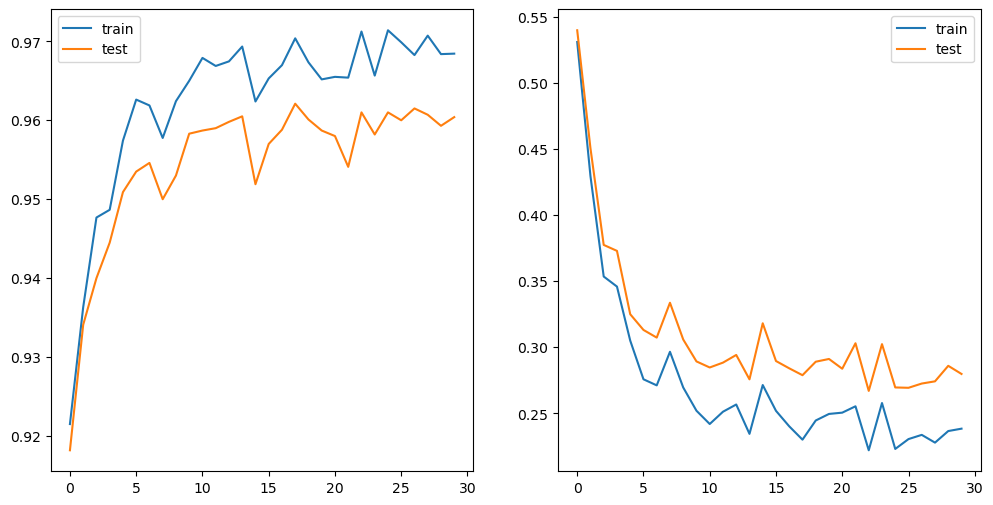

In [20]:
plot_results(results3)

### Added normalized initialization

In [21]:
NET4 = Network(30, loss=CrossEntropyLoss, init='normalized')
results4 = NET4.SGD(train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9601


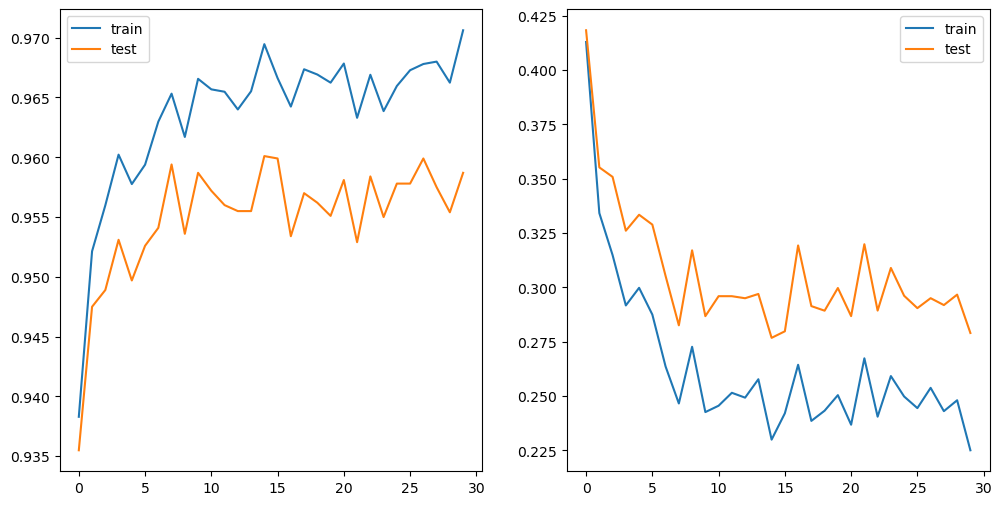

In [22]:
plot_results(results4)

## Early stopping
Early stopping, where the user does not have to specify the number of epochs in advance. For example, the
network can stop if for 5 epochs in a row the validation data accuracy has not improved.

 ##### Let's experiment with values like 3, 5, 10, and see how they affect your specific training scenario.

### Thresholds thre= $3$

In [23]:
NET5 = Network(30, loss=CrossEntropyLoss, init='normalized')
results5 = NET5.SGD_with_early(train_data, 
                    thre= 3, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)   

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished


0.9578


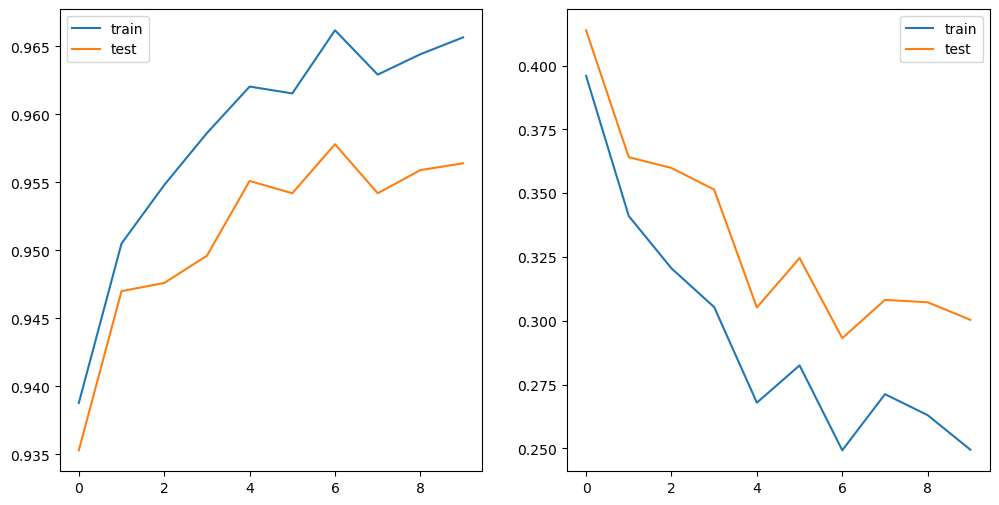

In [24]:
plot_results(results5)

### Thresholds thre= $5$

In [25]:
NET6 = Network(30, loss=CrossEntropyLoss, init='normalized')
results6 = NET6.SGD_with_early(train_data, 
                    thre= 5, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data) 

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished


0.9565


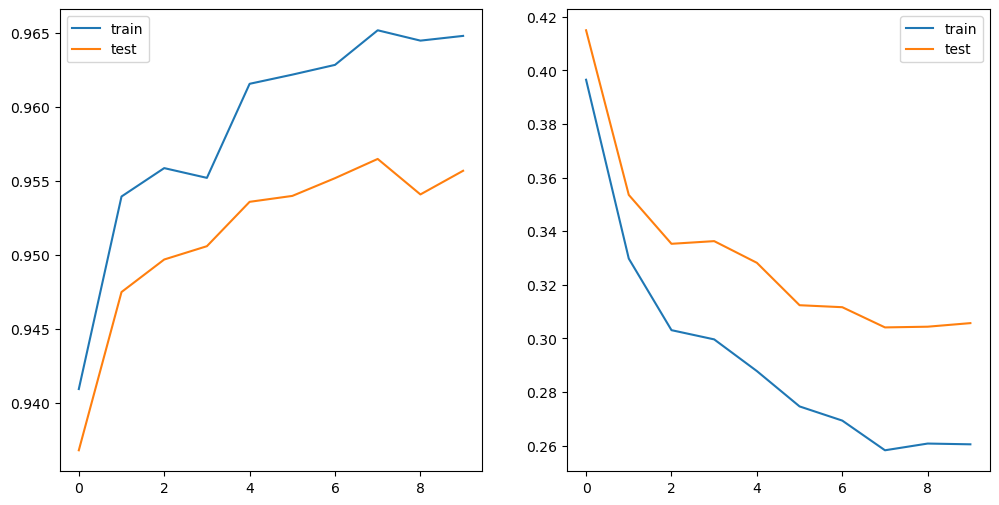

In [26]:
plot_results(results6)

### Thresholds thre= $7$

In [27]:
NET7 = Network(30, loss=CrossEntropyLoss, init='normalized')
results7 = NET7.SGD_with_early(train_data, 
                    thre= 7, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished


0.9559


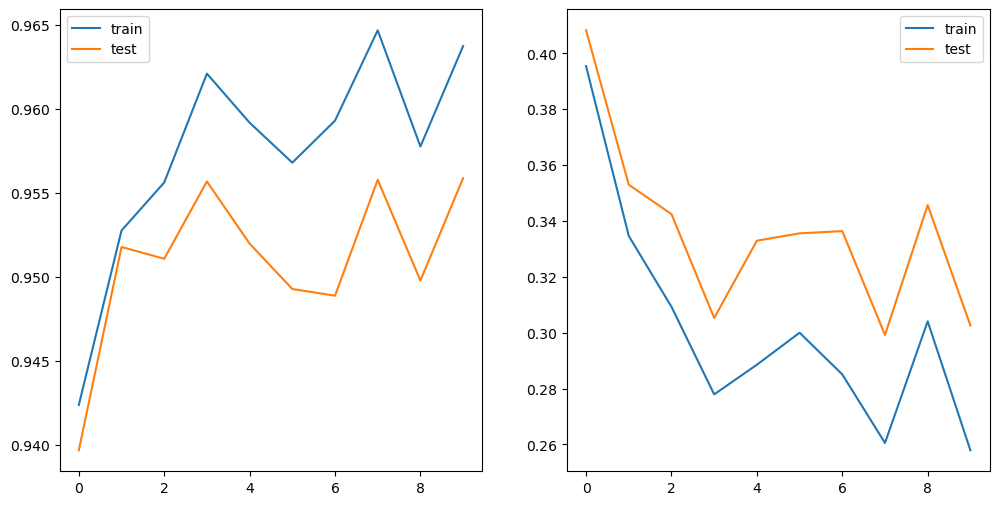

In [28]:
plot_results(results7)

## Comment on result

After applying early stopping with thresholds of 3, 5, and 7 epochs, the resulting validation accuracies were 0.9589, 0.9563, and 0.9607, respectively, compared to the initial accuracy of 0.9583. A threshold of 3 epochs led to a quick convergence with a slight improvement, while a threshold of 5 epochs resulted in a slightly lower accuracy, suggesting that further training did not significantly enhance performance. also threshold of 7 epochs without improvement yielded the highest final accuracy, indicating that allowing the model to train for an extended period was beneficial to increase the performance. 

Overall conclusion the threshold are not seem to change a lot on the perfomance of the model.

### Added data augmentation

In [29]:
def plot_digit(img):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    plt.imshow(1-img, cmap='gray')

In [30]:
def shifted_image(img, shift_r, shift_c):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    res = np.zeros_like(img)
    for row in range(IMG_LEN):
        new_row = row + shift_r
        if new_row >= 0 and new_row < IMG_LEN:
            for col in range(IMG_LEN):
                new_col = col + shift_c
                if new_col >= 0 and new_col < IMG_LEN:
                    res[new_row, new_col] = img[row, col]
    return np.reshape(res, (IMG_SIZE,))

(None, 6)

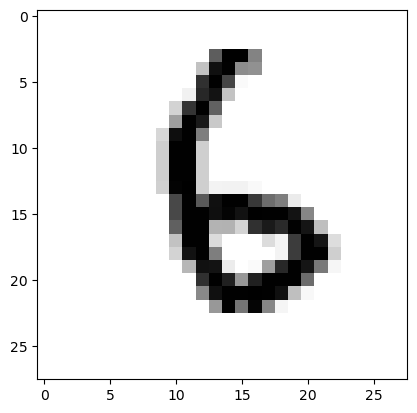

In [31]:
plot_digit(train_data[30][0]), train_data[30][1]

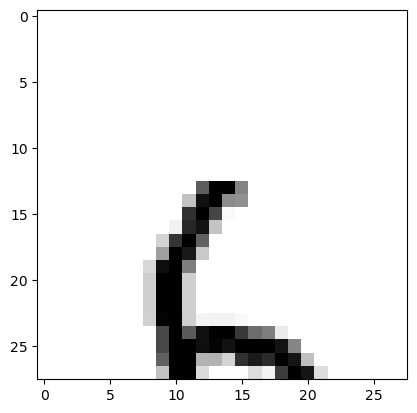

In [32]:
plot_digit(shifted_image(train_data[30][0], 10, -1))

In [33]:
expanded_train_data = []
for x, ylabel in train_data:
    expanded_train_data.append((x, ylabel))
    for r_shift, c_shift in [(+1, 0), (-1, 0), (0, +1), (0, -1)]:
        expanded_train_data.append((
            shifted_image(x, r_shift, c_shift),
            ylabel
        ))

In [34]:
len(expanded_train_data)

250000

### Network run on expanded data set

In [35]:
NET8 = Network(100, loss=CrossEntropyLoss, init='normalized')
results8 = NET5.SGD(expanded_train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9665


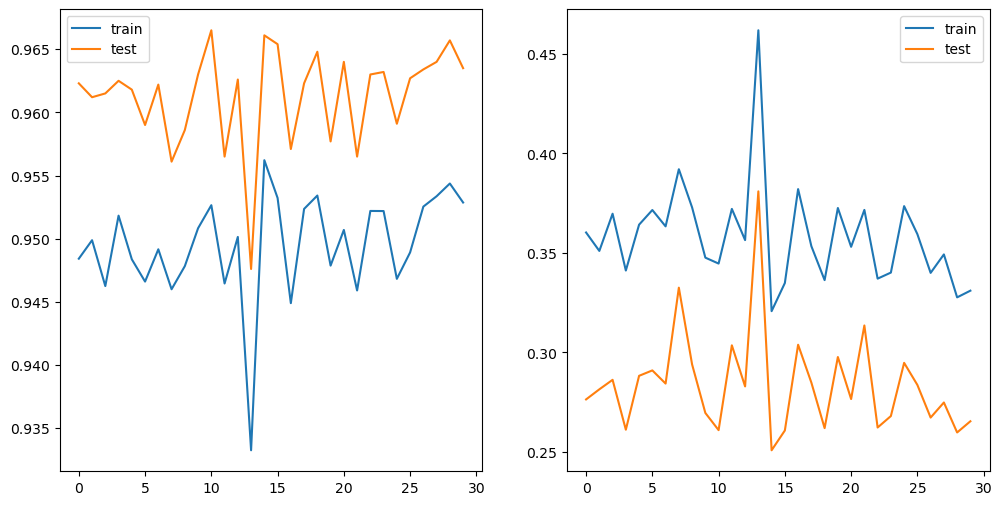

In [38]:
plot_results(results8)

### Finally, let's make it 100 neurons

Let's apply threshold to the network with 100 neurons 

In [ ]:
NET10 = Network(100, loss=CrossEntropyLoss, init='normalized')
results10 = NET10.SGD_with_early(expanded_train_data,
                      thre= 1e-1, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

In [ ]:
plot_results(results10)

### One last run with smaller learning rate and more epochs

In [ ]:
NET12 = Network(30, loss=CrossEntropyLoss, init='normalized')
results12 = NET12.SGD(expanded_train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.1, 
                    lmbda=10**(-4),
                    test_data=test_data)

In [ ]:
plot_results(results12)

## Variable learning rate.
For example, wait until the network does not improve according to the early stopping
rule. Then divide the learning rate by 10. Repeat that three times.

#### Let's divide learning late by 10

In [62]:
NET13 = Network(30, loss=CrossEntropyLoss, init='normalized')
results13 = NET13.SGD_with_early(train_data, 
                    thre= 7, 
                    mini_batch_size=10, 
                    eta=0.5/10, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished


In [ ]:
plot_results(results13)

## Problem 5: Fashion MNIST

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [54]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

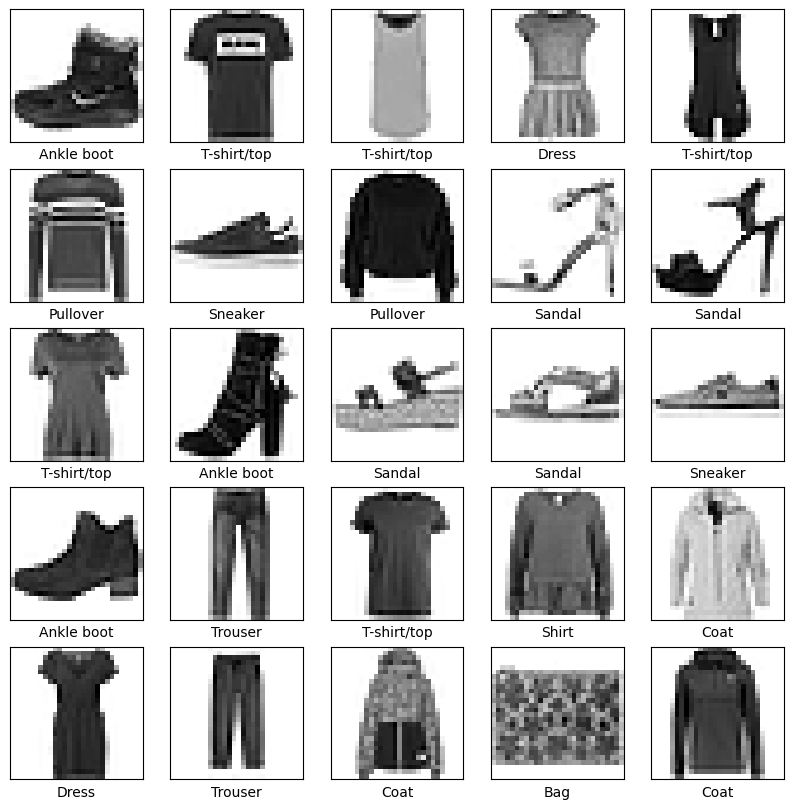

In [55]:
# Exploration of the data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [56]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

In [57]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

Epoch 1/10
1500/1500 [==============================] - 41s 26ms/step - loss: 0.5379 - accuracy: 0.8021 - val_loss: 0.4113 - val_accuracy: 0.8524
Epoch 2/10
1500/1500 [==============================] - 38s 25ms/step - loss: 0.3409 - accuracy: 0.8750 - val_loss: 0.3420 - val_accuracy: 0.8736
Epoch 3/10
1500/1500 [==============================] - 34s 23ms/step - loss: 0.2910 - accuracy: 0.8923 - val_loss: 0.2833 - val_accuracy: 0.8982
Epoch 4/10
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2617 - accuracy: 0.9024 - val_loss: 0.2689 - val_accuracy: 0.8992
Epoch 5/10
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2370 - accuracy: 0.9124 - val_loss: 0.2699 - val_accuracy: 0.9034
Epoch 6/10
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2144 - accuracy: 0.9195 - val_loss: 0.2540 - val_accuracy: 0.9067
Epoch 7/10
1500/1500 [==============================] - 37s 25ms/step - loss: 0.1954 - accuracy: 0.9280 - val_loss: 0.2542 -

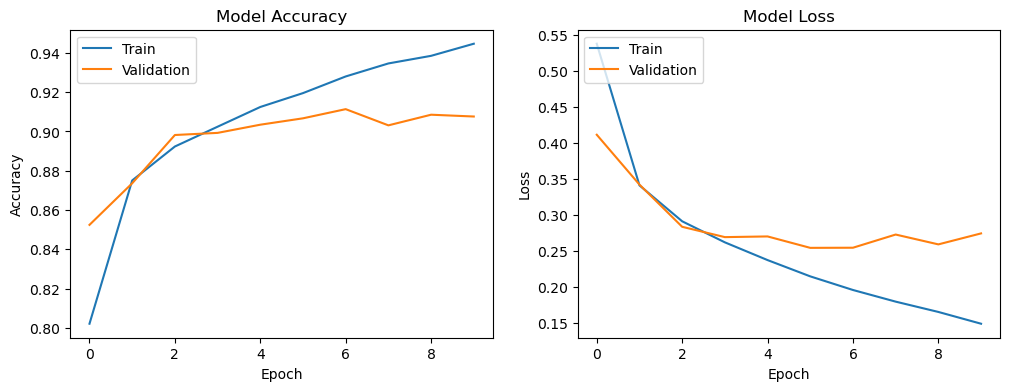

In [59]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
history = model.fit(train_images, train_labels,epochs=10, validation_split=0.2)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [60]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'\nTest accuracy: {accuracy}')

313/313 [==============================] - 3s 9ms/step - loss: 0.2930 - accuracy: 0.9015

Test accuracy: 0.9014999866485596


The convolutional model was trained on the Fashion MNIST dataset using TensorFlow's Keras module, it achieved a test accuracy of approximately 90.15%. It implies that the model successfully classified around 90.15% of unseen samples. 